# Predicting yield at University of California schools

In our project, we wanted to work with admission data from undergraduate institutions to learn more about the admission process in a more scientific context.

**Our main modelling goal for this project will be to determine the yield at an undergraduate school given information about the admitted class.** We believe it is a very interesting and practical question. Every year, during the admission season, colleges have to select students for the incoming freshmen year, but do not know how many of their offers will be accepted. If too few students accept their offers, the freshmen class will be under-enrolled, and school's resources will not be fully used. However, if too many students are admitted, the school will need to spend more resources to accommodate the unusually high number of students. 

Unfortunately, **admission data is legally protected, and only highly anonymized datasets are publicly available.** For this project, we decided to use the data from the University of California infocenter. The particular datasets we were interested in can be found here: https://www.universityofcalifornia.edu/infocenter/admissions-source-school. The data contains information about:

 - The number of applying, admitted and accepted students from each high school
 - The average GPA of applying, admitted and accepted students at each high school
 - Demographic data (students' race/ethnicity)
 - Locations of the high schools
 
The data is sorted by year and University of California campus.

We believe that the predictive power of these datasets might not be enough to accurately predict the yield (it only gives us access to very basic meta-information). Therefore, if the evaluations of our models show poor results, we are planning to use demographic information about the surveyed high schools/counties. To do that, we will most likely use the https://data.ca.gov/ repository.

## First look at our data

Our data is split into two datasets. The first one (which we will call `gpas` in the later parts of this notebook) contains mean GPA information by:

 - University of California campus
 - High School
 - Year
 - Category (applied, admitted, enrolled)
 
Whereas the second set (which we will call `counts`) contains the number of students in each of the categories *(applied, admitted, enrolled)*. The data is also grouped by:

 - University of California campus
 - High School
 - Year

In [1]:
import pandas as pd
%matplotlib inline
import pylab as plt
import numpy as np
import scipy as sc
import scipy.stats

In [2]:
gpas = pd.read_csv('data/FR_GPA_by_Inst_data_converted.csv')
counts = pd.read_csv('data/HS_by_Year_data_converted.csv')

After we have loaded our data, we will display the first few rows in each dataset.

In [3]:
gpas.head(12)

,Calculation1,Campus,City,County,Fall Term,Measure Names,School,Measure Values
0,21ST CENTURY EXPERIMENTAL SCH694223,Santa Cruz,n/a,Not Applicable,2017,Enrl GPA,21ST CENTURY EXPERIMENTAL SCH,NaN
1,21ST CENTURY EXPERIMENTAL SCH694223,Santa Barbara,n/a,Not Applicable,2017,Enrl GPA,21ST CENTURY EXPERIMENTAL SCH,NaN
2,21ST CENTURY EXPERIMENTAL SCH694223,San Diego,n/a,Not Applicable,2017,Enrl GPA,21ST CENTURY EXPERIMENTAL SCH,NaN
3,21ST CENTURY EXPERIMENTAL SCH694223,Los Angeles,n/a,Not Applicable,2017,Enrl GPA,21ST CENTURY EXPERIMENTAL SCH,NaN
4,21ST CENTURY EXPERIMENTAL SCH694223,Irvine,n/a,Not Applicable,2017,Enrl GPA,21ST CENTURY EXPERIMENTAL SCH,NaN
5,21ST CENTURY EXPERIMENTAL SCH694223,Davis,n/a,Not Applicable,2017,Enrl GPA,21ST CENTURY EXPERIMENTAL SCH,NaN
6,21ST CENTURY EXPERIMENTAL SCH694223,Berkeley,n/a,Not Applicable,2017,Enrl GPA,21ST CENTURY EXPERIMENTAL SCH,NaN
7,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,n/a,Not Applicable,2017,Enrl GPA,21ST CENTURY EXPERIMENTAL SCH,3.986667
8,21ST CENTURY EXPERIMENTAL SCH694223,Santa Cruz,n/a,Not Applicable,2017,Adm GPA,21ST CENTURY EXPERIMENTAL SCH,NaN
9,21ST CENTURY EXPERIMENTAL SCH694223,Santa Barbara,n/a,Not Applicable,2017,Adm GPA,21ST CENTURY EXPERIMENTAL SCH,3.999091


In [4]:
counts.head(6)

,Calculation1,Campus,City,County/State/ Territory,Fall Term,Measure Names,Uad Uc Ethn 6 Cat,Measure Values
0,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2017,enr,All,12.0
1,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2017,adm,All,30.0
2,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2017,app,All,43.0
3,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2016,enr,Inter- national,5.0
4,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2016,adm,Inter- national,12.0
5,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2016,app,Inter- national,18.0


## About the structure of the data

Unfortunately, the datasets were given to us in a fairly uncomfortable format. Each of the rows specifies:
 - Name of the high school
 - City of the high school
 - County/State/Teritory of the high school
 - University of California campus
 - Year.
 
However, instead of specifying the numerical data in designated columns, the datasets use the *measure name/measure value* approach. That means, that **only one numerical value is given per row.** Instead of putting multiple measurements per each row, the datasets' designers decided to create multiple copies of each row with one measurement per copy. The `Measure Names` column is used to indicate the type of the measurement in the row. The `Measure Values` column specifies the actual value of the measurement.

For example, a row of type:

| campus_name | school_name | avg_enrolled_gpa | avg_accepted_gpa | enrolled_student_count | accepted_student_count |
|-------------|-------------|------------------|------------------|------------------------|------------------------|
| Campus A    | School B    | 2.0              | 3.0              | 50                     | 80                     |

Would be converted to multiple rows like:

| campus_name | school_name | measurement name       | measurement value |
|-------------|-------------|------------------------|-------------------|
| Campus A    | School B    | avg_enrolled_gpa       | 2.0               |
| Campus A    | School B    | avg_accepted_gpa       | 3.0               |
| Campus A    | School B    | enrolled_student_count | 50                |
| Campus A    | School B    | accepted_student_count | 80                |


Moreover, these rows have been split to two separate files, which further complicates working with the data. We are expecting, that we will need to put significant effort into the data cleaning part of the project.
 

## Data exploration

In order to better understand the data we will be working with, we decided to perform a few data exploration tasks.

### Ratio of NaN fields

One of the concerning properties of our datasets was the large number of `NaN` fields. In order to anonymize the data, the Unviersity of California decided to remove information about GPAs for high schools with less than 3 student datapoints, and count information for high schools with less than 5 datapoints.

In this exercise, we dicided to find out the ratio of `NaN` fields to actual fields.

In [5]:
gpas_row_count = len(gpas)
gpas_not_nan_count = gpas[~gpas['Measure Values'].isnull()]['Measure Values'].count()
gpas_nan_ratio = gpas_not_nan_count/gpas_row_count

print('Number of rows in the GPA table: ', gpas_row_count)
print('Number of valid GPA values: ', gpas_not_nan_count)
print('Ratio of valid GPA values to all values: ', gpas_nan_ratio)

Number of rows in the GPA table:  888066
Number of valid GPA values:  570305
Ratio of valid GPA values to all values:  0.6421876301986564


Next, we repeat the same process for the `student count` data:

In [6]:
student_num_row_count = len(counts)
student_num_not_nan_count = counts[~counts['Measure Values'].isnull()]['Measure Values'].count()
student_num_nan_ratio = student_num_not_nan_count/student_num_row_count

print('Number of rows in the student count table: ', student_num_row_count)
print('Number of valid student count values: ', student_num_not_nan_count)
print('Ratio of valid student count values to all values: ', student_num_nan_ratio)

Number of rows in the student count table:  1048575
Number of valid student count values:  737957
Ratio of valid student count values to all values:  0.7037713086808287


#### Results

As we can see, a large number of rows in our dataset **do not contain valid data.** We will have to properly deal with this problem while working on our data cleaning component.

### High school applicant GPAs

We thought it would be interesting to learn which schools in our datasets sent the most qualified candidates as measured by student GPA. In order to find that information, we decided to sort the schools by their mean applicant GPA.

First we will show the best schools by applicant GPA:

In [7]:
school_gpas = gpas[gpas['Measure Names'] == 'App GPA'].\
              groupby('Calculation1')['Measure Values'].\
              mean()

school_gpas.sort_values(ascending=[False])[0:10]

Calculation1
KINGS PARK HIGH SCHOOL332695           4.360000
MERROL HYDE MAGNET SCHOOL430893        4.340000
HUDSON'S BAY HIGH SCHOOL481475         4.286667
WILLIAM J BRENNAN HIGH SCHOOL446239    4.270000
OCONEE COUNTY HIGH SCHOOL113190        4.270000
VALLEY STREAM SOUTH HS335712           4.268000
JOHN S DAVIDSON FINE ARTS SCH110294    4.258333
KINGS HIGH SCHOOL362800                4.258000
JAMES S RICKARDS HIGH SCHOOL101663     4.258000
FAYETTE COUNTY HIGH SCHOOL111275       4.250000
Name: Measure Values, dtype: float64

Next we will look at the schools with lowest GPAs:

In [8]:
school_gpas.sort_values(ascending=[True])[0:10]

Calculation1
MARYKNOLL CONVENT SCHOOL670580         2.627000
SAINT COLUMBAS HIGH SCHOOL671880       2.658000
DUBAI MODERN EDUCATION SCHOOL697053    2.664000
AMERICAN ACADEMY FOR GIRLS683085       2.674000
JAI HIND COLLEGE671659                 2.734132
LOS ANGELES BIG PICTURE HS051739       2.752580
GOOD HOPE SCHOOL670500                 2.792000
NORTHWEST ACADEMY290004                2.822000
FROEBELS INTERNATIONAL SCHOOL690259    2.836000
BRITISH COLUMBIA ACADEMY694214         2.854000
Name: Measure Values, dtype: float64

Interestingly, **all of these schools were located in California**. This brings us to another interesting question about our dataset composition.

### High school location breakdown

In our previous excercise we noticed that the top 10 "best" schools and top 10 "worst" schools in our dataset were located in California. In this section, we would like to learn how many of the considered schools were located:
 - in California
 - in the US but outside California
 - outside of the US
 
In order to perform this task, we notice the following conjecture about the format of the `County/State/Territory` column in the `counts` dataset:

 - If the school is located in California, the column contains the county name
 - If the school is located in the US, the column contains the name of the state
 - If the school is located outside of the US, the column contains the name of the country (in all caps)

First we will validate our data:

In [9]:
# We extracted the list of California counties, and US teritories from the list of unique locations
ca_counties = ['Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa', 'Contra Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt', 'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Mendocino', 'Merced', 'Modoc', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange', 'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito', 'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin', 'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara', 'Santa Cruz', 'Shasta', 'Sierra', 'Siskiyou', 'Solano', 'Sonoma', 'Stanislaus', 'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne', 'Ventura', 'Yolo', 'Yuba']
us_states_and_territories = ['American Samoa', 'Northern Mariana Islands', 'U.S. Armed Forces –\xa0Pacific', 'U.S. Armed Forces –\xa0Europe', 'Puerto Rico', 'Guam', 'District of Columbia', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

all_locations = list(counts['County/State/ Territory'].unique())
country_names = [l for l in all_locations
                 if l not in ca_counties and
                    l not in us_states_and_territories and
                    l is not np.nan]

# Sanity check - our contry_names should be in all caps:
for country_name in country_names:
    assert(country_name == country_name.upper())


Next we will perform the actual calculations:

In [10]:
total_schools = counts['Calculation1'].unique().size
california_schools = counts[counts['County/State/ Territory'].isin(ca_counties)]\
                           ['Calculation1'].unique().size
us_non_ca_schools  = counts[counts['County/State/ Territory'].isin(us_states_and_territories)]\
                           ['Calculation1'].unique().size
foreign_schools    = counts[counts['County/State/ Territory'].isin(country_names)]\
                           ['Calculation1'].unique().size

print('Total number of schools: ', total_schools)
print('Ratio of schools in california: ', california_schools/total_schools)
print('Ratio of schools in the US (but not CA): ', us_non_ca_schools/total_schools)
print('Ratio of foreign schools: ', foreign_schools/total_schools)


Total number of schools:  3077
Ratio of schools in california:  0.31036724081897954
Ratio of schools in the US (but not CA):  0.512187195320117
Ratio of foreign schools:  0.17679558011049723


## Raw data summary

To summarize, we belive our data contains very interesting information that could be helpful to predict the student yield ratio. However, due to a peculiar format of the data, we will need to put a large amount of work into data cleanup, and preprocessing. We will move on to that task in our `preprocessing.ipynb` notebook.

## Visualizations on the preprocessed data

To show the type of information stored in our dataset, we decided to show it on a variety of different graphs.

In [11]:
packed = pd.read_csv('data/processed.csv')

### Applying vs Admitted vs Enrolled GPA

We wanted to see what the differences between applying, admitted, and enrolled students' GPAs are. In order to do that, we used our `*_num` and `*_gpa` columns to properly compute the average GPA of students at the UC universities.

Unsurprisingly, the applying student pool had the lowest mean GPA. Moreover, the enrolled student pool had lower GPAs than admitted students. This makes sense, since the students from the top of the accepted pool are more likely to get offers from other universities.

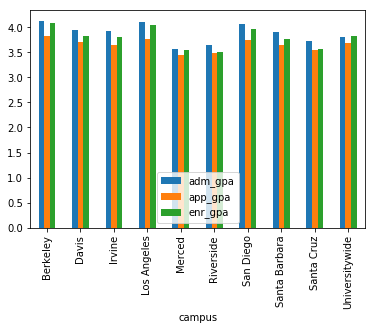

In [12]:
def avg_gpa_finder(data):
    d = {}
    d['adm_gpa'] = (data['adm_gpa'] * data['adm_num']).sum() / (data[data['adm_gpa'].notnull()]['adm_num'].sum())
    d['app_gpa'] = (data['app_gpa'] * data['app_num']).sum() / (data[data['app_gpa'].notnull()]['app_num'].sum())
    d['enr_gpa'] = (data['enr_gpa'] * data['enr_num']).sum() / (data[data['enr_gpa'].notnull()]['enr_num'].sum())
    return pd.Series(d, index=['adm_gpa', 'app_gpa', 'enr_gpa'])

packed.groupby(['campus']).apply(avg_gpa_finder).plot.bar()

### Average Admitted GPA Inflation over the years

We are interested in exploring how the average admitted, enrolled and applied GPAs have changed over the years. The line plots describe the trend, in which the GPA tends to increase before 2007 and suddenly drops afterwards. After 2010, the increasing trend of GPAs goes on. So, during recent years, GPA does get inflated. This suggests to us that, in order to predict the ratio between the applicants and the students who were actually enrolled, we might need to look at data in recent years. 

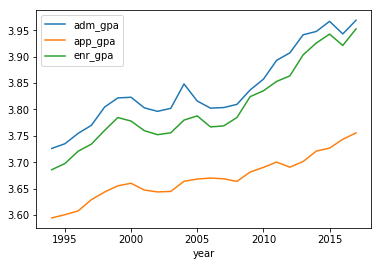

In [13]:
packed.groupby(['year']).apply(avg_gpa_finder).plot.line()

### Admitted Students vs Enrolled Students 

The goal of this project is to predict the ratio between the enrolled students and the admitted students in the future. Therefore, a scatterplot between the enrolled and the admitted from the past would give us an indication of how our model needs to be built. The data regarding "Universitywide" is excluded from this plot because we are interested in each individual university.

The ratio of enrolled to admitted could be a good metric for the desirability of a campus. For instance, Berkely and Santa Barbara admitted a similar amount of students, but many more students enrolled at Berkely, indicating that Berkely could be more desirable for students.

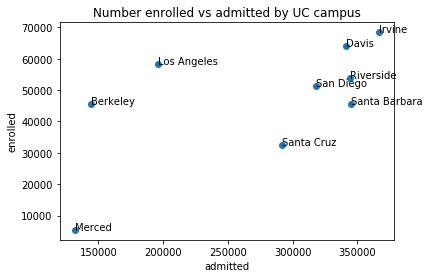

In [14]:
def adm_enr_num(data):
    d = {}
    d['adm_num'] = data['adm_num'].sum()
    d['enr_num'] = data['enr_num'].sum()
    return pd.Series(d, index=['adm_num', 'enr_num'])

enr_adm_num_c = packed[packed['campus'] != 'Universitywide'].groupby(['campus']).apply(adm_enr_num)

x, y = enr_adm_num_c.adm_num, enr_adm_num_c.enr_num # should exclude the Universitywide data
campus_names = ['Berkeley', 'Irvine', 'Davis', 'Los Angeles', 'Merced', 'Riverside', 'San Diego',
               'Santa Barbara', 'Santa Cruz']
campus_names.sort()

plt.scatter(x, y)
plt.xlabel('admitted')
plt.ylabel('enrolled')
plt.title('Number enrolled vs admitted by UC campus')

for i in range(0, len(campus_names)):
    plt.annotate(campus_names[i], (x[i], y[i]))